In [10]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")

# Charger dataset

In [11]:
batch_s = 64
data = tf.keras.preprocessing.image_dataset_from_directory("dataset/Portraits/", label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files.


In [12]:
data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

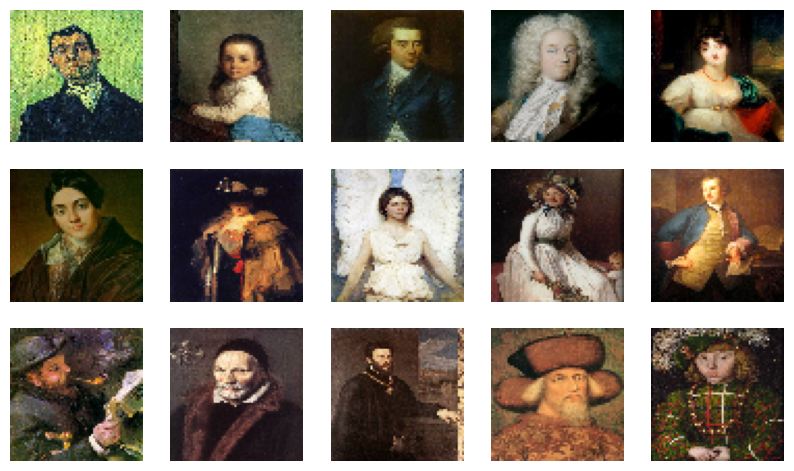

In [13]:
# Affiche quelques images
images = next(iter(data))
plt.figure(figsize=(10,10))
for i in range(15): 
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

In [14]:
# Normalisation entre 0 et 1
data = data.map(lambda x: x / 255.0)

In [15]:
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

# Construire modèle GAN

## 1/ Generator

In [16]:
latent_dim = 100

generator = Sequential()
generator.add(Dense(4*4*256, activation="relu", input_dim=latent_dim))
generator.add(Reshape((4,4,256))) 
generator.add(UpSampling2D())      # 8x8
generator.add(Conv2D(256, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))

generator.add(UpSampling2D())       # 16x16
generator.add(Conv2D(256, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))

generator.add(UpSampling2D())       # 32x32
generator.add(Conv2D(256, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))

generator.add(UpSampling2D())       # 64x64
generator.add(Conv2D(128, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))    

generator.add(Conv2D(64, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu")) 

generator.add(Conv2D(3, kernel_size=3, padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 3)      │         1,731 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,558,339 (9.76 MB)

 Trainable params: 2,556,419 (9.75 MB)

 Non-trainable params: 1,920 (7.50 KB)

Créer un image depuis generator

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

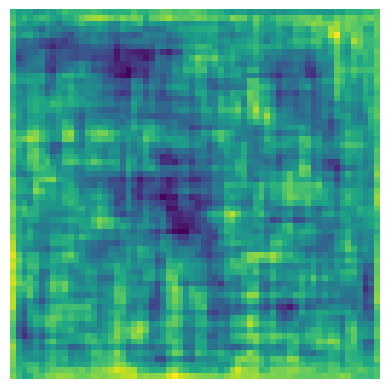

In [17]:
im = tf.random.normal([1, latent_dim])
generated_im = generator(im, training=False)
plt.imshow(generated_im[0,:,:,0])
plt.axis("off")

## 2/ Discriminator

In [25]:
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))       
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
#discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,605,185 (6.12 MB)

 Trainable params: 1,603,265 (6.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [30]:
predict = discriminator(generated_im)
print(predict)

tf.Tensor([[0.50007075]], shape=(1, 1), dtype=float32)


**Le résultat est 50/50 parce que le discriminator n'est pas encore formé**

# GAN Training

In [76]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Générer les images fausses
        generated_imgs = self.generator(seed)
        # Combinez les images réelles et les images fausses
        combined_images = tf.concat([real_images, generated_imgs], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Ajouter les bruits aléatoires aux labels 
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Former le discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # tous les images sont réelles
        misleading_labels = tf.ones((batch_size, 1))

        # Former le generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Mettre à jour la métrique
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [78]:
epochs = 200
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()

model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)
history = model.fit(data, epochs=epochs)

Epoch 1/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - d_loss: 0.6459 - g_loss: 0.7946
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - d_loss: 0.6740 - g_loss: 0.7141
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - d_loss: 0.6746 - g_loss: 0.6883
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - d_loss: 0.6476 - g_loss: 0.7304
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - d_loss: 0.6419 - g_loss: 0.7617
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - d_loss: 0.5964 - g_loss: 0.8227
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - d_loss: 0.5917 - g_loss: 0.8829
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - d_loss: 0.6108 - g_loss: 0.9632
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - d_loss: 0.6128 - g_loss: 0.9196
Epoch 10/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - d_loss: 0.5984 - g_loss: 0.8327
Epoch 11/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - d_loss: 0.6435 - g_loss: 0.8956
Epoch 12/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 

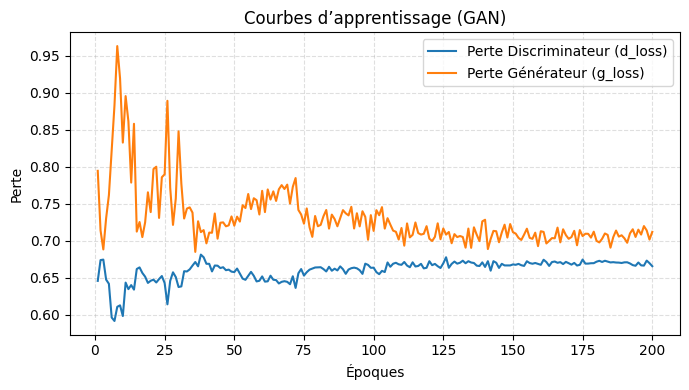

In [81]:
d_loss = history.history.get("d_loss", [])
g_loss = history.history.get("g_loss", [])

n = min(len(d_loss), len(g_loss))
epochs_axis = np.arange(1, n + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs_axis, d_loss[:n], label="Perte Discriminateur (d_loss)")
plt.plot(epochs_axis, g_loss[:n], label="Perte Générateur (g_loss)")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.title("Courbes d’apprentissage (GAN)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# GAN crée des oeuvres d'art

In [86]:
num_img=18

# Générer et sauvegarder les images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
    return Generated_Paintings

Images = Potrait_Generator()

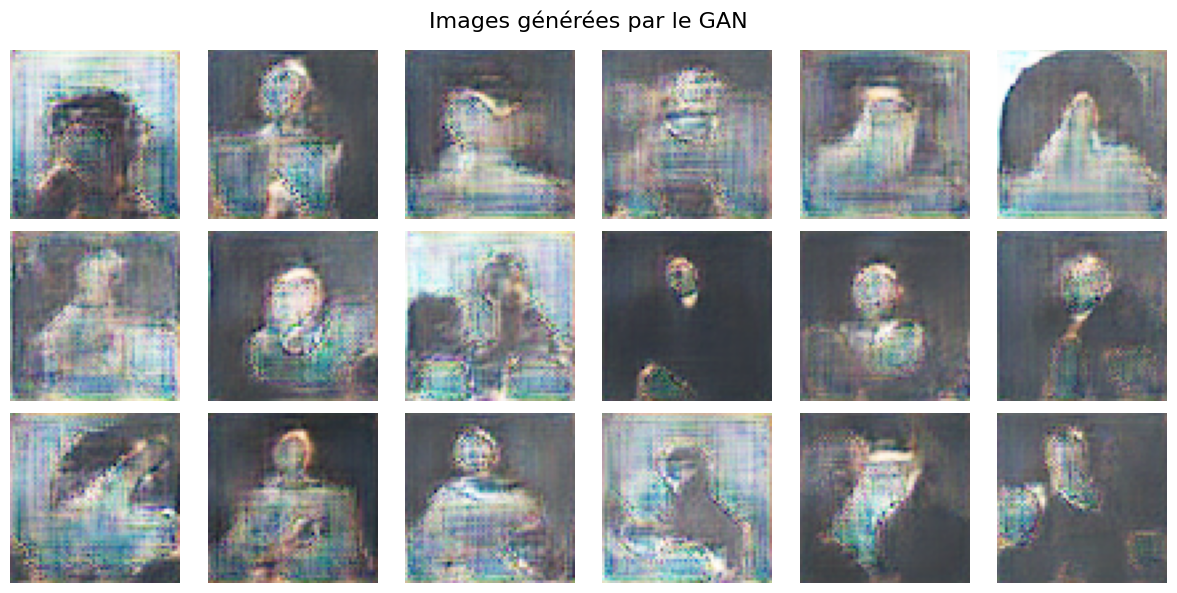

In [87]:
plt.figure(figsize=(12, 6))
for i, img in enumerate(Images):
    plt.subplot(3, 6, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Images générées par le GAN", fontsize=16)
plt.tight_layout()
plt.show()

In [88]:
model.save("GAN.keras")